## **Final Work Report: Generation of Bird Sounds**

**Students:** Edward García Hernández y Daniel Esteban Salazar Camacho

**Professor:** Santiago Echeverry Arteaga 

This jupyter notebook shows the audio classification done for a database of recorded African bird calls around northern Mount Kenya. The database consists of a folder of $10$ birds and each one contains around $90$ audios in *ogg* format. In addition, it brings a metadata file called *train_metadata.csv* with the labels and paths to the respective audios.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

import os

#for loading and visualizing audio files
import librosa 
import librosa.display

#to play audio
import IPython.display as ipd

import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio

from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

from torch.utils.data import random_split

import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

## **Data visualization**

In [2]:
birds_df = pd.read_csv(os.path.expanduser('~/Fisica Computacional 2/project2_birds/proyecto-clef/train_m_audio_1/train_metadata.csv'), delimiter=',')
birds_df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg
2,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363502,abethr1/XC363502.ogg
3,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/363503,abethr1/XC363503.ogg
4,abethr1,[],"['call', 'song']",-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://www.xeno-canto.org/363504,abethr1/XC363504.ogg


In [3]:
#DataFrame with the columns of interest

birds_names = ['afecuc1', 'afpwag1', 'bcbeat1', 'brubru1', 'gobbun1', 'grbcam1', 'piecro1', 'tamdov1', 'trobou1', 'vilwea1']

columns = ['secondary_labels', 'type', 'latitude', 'longitude', 'scientific_name', 'common_name', 'author', 'license', 'rating', 'url']

birds_df = birds_df.drop(columns, axis=1)
birds_df = birds_df[birds_df['primary_label'].isin(birds_names)].reindex()

birds_df.reset_index(drop=True, inplace=True)

birds_df

,primary_label,filename
0,afecuc1,afecuc1/XC115261.ogg
1,afecuc1,afecuc1/XC115262.ogg
2,afecuc1,afecuc1/XC118454.ogg
3,afecuc1,afecuc1/XC125132.ogg
4,afecuc1,afecuc1/XC125133.ogg
...,...,...
877,vilwea1,vilwea1/XC600201.ogg
878,vilwea1,vilwea1/XC620877.ogg
879,vilwea1,vilwea1/XC700690.ogg
880,vilwea1,vilwea1/XC700693.ogg


In [4]:
#Label encoding
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

birds_df['primary_label'].unique()
label_encoder.fit(birds_df['primary_label'].unique())
birds_df['label_encoded'] = label_encoder.transform(birds_df['primary_label'])

birds_df

,primary_label,filename,label_encoded
0,afecuc1,afecuc1/XC115261.ogg,0
1,afecuc1,afecuc1/XC115262.ogg,0
2,afecuc1,afecuc1/XC118454.ogg,0
3,afecuc1,afecuc1/XC125132.ogg,0
4,afecuc1,afecuc1/XC125133.ogg,0
...,...,...,...
877,vilwea1,vilwea1/XC600201.ogg,9
878,vilwea1,vilwea1/XC620877.ogg,9
879,vilwea1,vilwea1/XC700690.ogg,9
880,vilwea1,vilwea1/XC700693.ogg,9


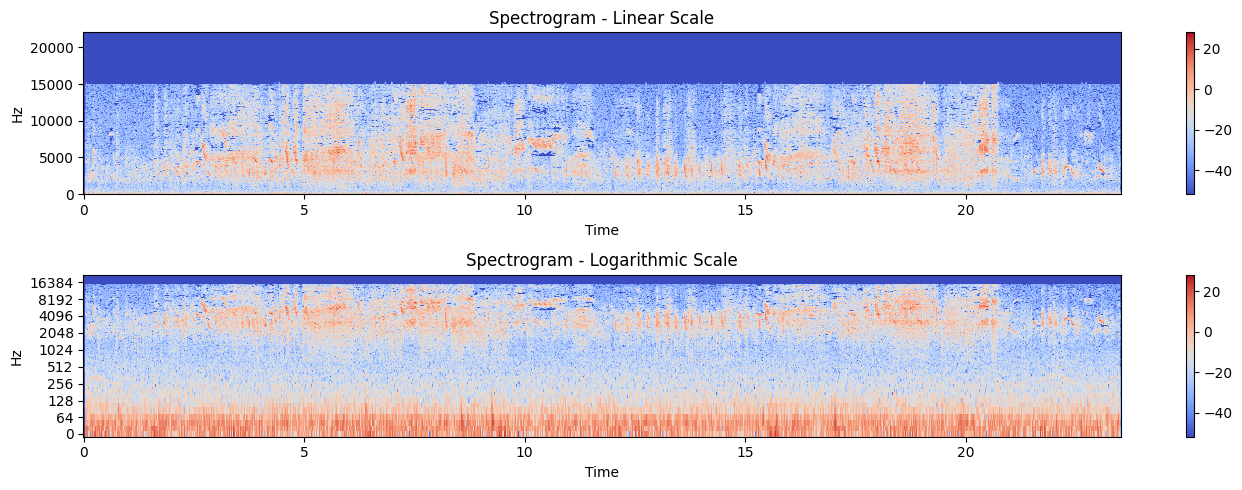

In [5]:
#Visualization of the spectrograms

destination_directory = os.path.expanduser('~/Fisica Computacional 2/project2_birds/proyecto-clef/train_m_audio_1')

# List of bird folders after extraction
folders_birds = os.listdir(os.path.join(destination_directory, "train_m_audio"))

# Iterating through the bird folders and audio files
for bird_folder in folders_birds:

    bird_folder_path = os.path.join(destination_directory, "train_m_audio", bird_folder)
    audio_files = os.listdir(bird_folder_path)

    for audio_file in audio_files:

        audio_path = os.path.join(bird_folder_path, audio_file)

        if os.path.isfile(audio_path):
            x, sr = librosa.load(audio_path, sr=44100)

            # Convert to spectrogram and apply logarithmic transformation
            X = librosa.stft(x)
            Xdb = librosa.amplitude_to_db(abs(X))

            plt.figure(figsize=(14, 5))
            plt.subplot(2, 1, 1)
            librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
            plt.colorbar()
            plt.title("Spectrogram - Linear Scale")

            plt.subplot(2, 1, 2)
            librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
            plt.colorbar()
            plt.title("Spectrogram - Logarithmic Scale")

            plt.tight_layout()
            plt.show()

            break

    break

## **Treatment of spectrograms**

This section shows the preparation of the data for the future training of the model. In particular, the following transformations are performed: Resampling and converting to stereo, Resize to the same length, Audio Augmentation-Time Shift, Convert to mel Spectrogram, Data Augmentation-Time and Frequency Masking.

Firstly, the audios are read with the *open* function. Then, since we don't know if there are stereo or mono audios and since the model expects all elements to have the same dimensions, it will change the mono files to stereo, duplicating the first channel in the second. Then, since some of the sound files may be sampled at a test rate of $48000~Hz$ while others may be sampled at a rate of $44100~Hz$, therefore all audio will be standardized and analyzed. at the same polling frequency. Subsequently, all audio samples will be resized to have the same duration, either by extending their duration by padding with silence, or by truncating it. The data in the audio signal will then be lost without using a time shift to shift the audio left or right by a random amount. Then the audio convinced was changed into a spectrogram of Mel. Next, an increase will be made to the Mel spectrogram using: frequency mask and time mask.

In [6]:
#Read audio from a file

class AudioUtil():
  
  @staticmethod

  def open(audio_file):

    sig, sr = torchaudio.load(audio_file)
    
    return (sig, sr)

    # Convert the given audio to the desired number of channels

  @staticmethod

  def rechannel(aud, new_channel):

    sig, sr = aud

    if (sig.shape[0] == new_channel):

      return aud

    if (new_channel == 1):

      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]

    else:

      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig, sig])

    return ((resig, sr))

# Since Resample applies to a single channel, we resample one channel at a time

  @staticmethod

  def resample(aud, newsr):

    sig, sr = aud

    if (sr == newsr):

      return aud

    num_channels = sig.shape[0]

    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])

    if (num_channels > 1):

      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))

# Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds

  @staticmethod

  def pad_trunc(aud, max_ms):

    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):

      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):

      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)

# Shifts the signal to the left or right by some percent. Values at the end are 'wrapped around' to the start of the transformed signal.

  @staticmethod

  def time_shift(aud, shift_limit):

    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)

    return (sig.roll(shift_amt), sr)

# Generate a Spectrogram

  @staticmethod

  def spectro_gram(aud, n_mels = 64, n_fft = 1024, hop_len = None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = transforms.MelSpectrogram(sr, n_fft = n_fft, hop_length = hop_len, n_mels = n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db = top_db)(spec)

    return (spec)

# Augment the Spectrogram by masking out some sections of it in both the frequency dimension and the time dimension
#to prevent overfitting and to help the model generalise better. The masked sections are  replaced with the mean value.

  @staticmethod

  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels

    for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    
    for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

In [7]:
# Sound Dataset

class SoundDS(Dataset):
  
  def __init__(self, df, data_path):

    self.df = df
    self.data_path = str(data_path)
    self.duration = 4000
    self.sr = 44100
    self.channel = 2
    self.shift_pct = 0.4
            

  # Number of items in dataset

  def __len__(self):

    return len(self.df)    
    

  # Get i'th item in dataset

  def __getitem__(self, idx):

    # Absolute file path of the audio file - concatenate the audio directory with the relative path
    audio_file = self.data_path + self.df.loc[idx, 'filename']

    # Get the labels
    class_id = self.df.loc[idx, 'label_encoded']

    aud = AudioUtil.open(audio_file)
    
    # Some sounds have a higher sample rate, or fewer channels compared to the  majority. So make all sounds have the same number of channels and same 
    # sample rate. Unless the sample rate is the same, the pad_trunc will still result in arrays of different lengths, even though the sound duration is the same.
    
    reaud = AudioUtil.resample(aud, self.sr)
    rechan = AudioUtil.rechannel(reaud, self.channel)

    dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels = 64, n_fft = 1024, hop_len = None)
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct = 0.1, n_freq_masks = 2, n_time_masks = 2)

    return aug_sgram, class_id

In [8]:
data_path = 'train_m_audio_1/train_m_audio/'

myds = SoundDS(birds_df, data_path)

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size = 16, shuffle = True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size = 16, shuffle = False)


## **Build Model**

In [9]:
# Residual Block

class ResidualBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), stride=stride, padding=(1, 1))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), stride=1, padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(out_channels)


        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1), stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.bn1(out)
        
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.bn2(out)


        out += self.shortcut(residual)
        out = nn.ReLU()(out)
        
        return out

class AudioClassifier(nn.Module):
    def __init__(self):
        super(AudioClassifier, self).__init__()
        
        # Residual Blocks
        self.residual1 = ResidualBlock(2, 8, stride=2)
        self.residual2 = ResidualBlock(8, 16, stride=2)
        self.residual3 = ResidualBlock(16, 32, stride=2)
        self.residual4 = ResidualBlock(32, 64, stride=2)
        self.residual5 = ResidualBlock(64, 128, stride=2)

        # Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size = 1)
        self.lin = nn.Linear(128, 10)

    def forward(self, x):
        
        # Residual Blocks 
        x = self.residual1(x)
        x = self.residual2(x)
        x = self.residual3(x)
        x = self.residual4(x)
        #x = self.auto(x)    
        x = self.residual5(x)
        
        # classification layers
        x = self.ap(x)
        x = x.view(x.shape[0], -1)
        x = self.lin(x)
        
        return x

#Build the model and put it on the GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)

# Verify that it is in CUDA
next(myModel.parameters()).device

device(type='cpu')

In [12]:
# Training Loop

def training(model, train_dl, num_epochs):

  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.001,
                                                steps_per_epoch = int(len(train_dl)),
                                                epochs = num_epochs,
                                                anneal_strategy = 'linear')

  # Repeat for each epoch

  for epoch in range(num_epochs):

    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set

    for i, data in enumerate(train_dl):
        
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]
    
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction

    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

  print('Finished Training')
  
num_epochs = 60 
training(myModel, train_dl, num_epochs)

Epoch: 0, Loss: 2.36, Accuracy: 0.10
Epoch: 1, Loss: 2.24, Accuracy: 0.20
Epoch: 2, Loss: 2.05, Accuracy: 0.31
Epoch: 3, Loss: 1.83, Accuracy: 0.42
Epoch: 4, Loss: 1.66, Accuracy: 0.45
Epoch: 5, Loss: 1.52, Accuracy: 0.49
Epoch: 6, Loss: 1.46, Accuracy: 0.53
Epoch: 7, Loss: 1.30, Accuracy: 0.59
Epoch: 8, Loss: 1.32, Accuracy: 0.59
Epoch: 9, Loss: 1.28, Accuracy: 0.60
Epoch: 10, Loss: 1.16, Accuracy: 0.63
Epoch: 11, Loss: 1.10, Accuracy: 0.65
Epoch: 12, Loss: 1.03, Accuracy: 0.70
Epoch: 13, Loss: 0.95, Accuracy: 0.71
Epoch: 14, Loss: 0.99, Accuracy: 0.68
Epoch: 15, Loss: 0.89, Accuracy: 0.70
Epoch: 16, Loss: 0.85, Accuracy: 0.72
Epoch: 17, Loss: 0.87, Accuracy: 0.73
Epoch: 18, Loss: 0.75, Accuracy: 0.77
Epoch: 19, Loss: 0.72, Accuracy: 0.77
Epoch: 20, Loss: 0.70, Accuracy: 0.78
Epoch: 21, Loss: 0.67, Accuracy: 0.78
Epoch: 22, Loss: 0.68, Accuracy: 0.78
Epoch: 23, Loss: 0.67, Accuracy: 0.80
Epoch: 24, Loss: 0.62, Accuracy: 0.81
Epoch: 25, Loss: 0.57, Accuracy: 0.82
Epoch: 26, Loss: 0.53,

In [13]:
# Inference

def inference (model, val_dl):

  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates

  with torch.no_grad():

    for data in val_dl:
      
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
    
  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

# Run inference on trained model with the validation set
inference(myModel, val_dl)

Accuracy: 0.73, Total items: 176


In [14]:
data_df = pd.read_csv(os.path.expanduser('~/Fisica Computacional 2/project2_birds/proyecto-clef/data.csv'), delimiter=',')
data_df.head()

,epoch,loss,accuracy
0,0,2.36,0.10
1,1,2.24,0.20
2,2,2.05,0.31
3,3,1.83,0.42
4,4,1.66,0.45


Text(0.5, 1.0, 'Loss vs Epoch')

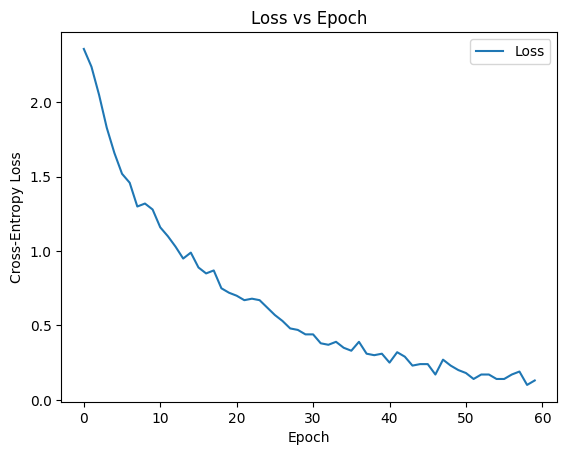

In [16]:
plt.plot(data_df['epoch'], data_df['loss'], label = 'Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.title('Loss vs Epoch')

Text(0.5, 1.0, 'Training Accuracy vs Epoch')

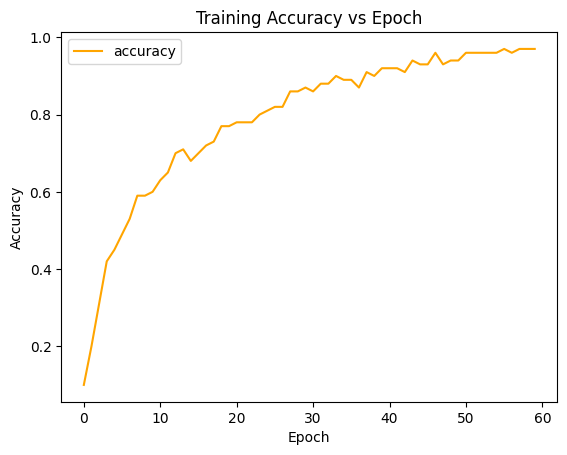

In [17]:
plt.plot(data_df['epoch'], data_df['accuracy'], color = 'orange', label = 'accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Epoch')